Background distribution: uniform, 50k events   
signal distribution: normal, centered on 60th bin, sdt 5 bin, 500 events

ToDo
- [x] generate data $o_i$ and $e_i$
- [x] $\chi^2$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qubovert as qv

In [31]:
# Function definitions

# only nearest neighbours, i.e. matrix with 0s on the diagonal and 1s on the one upper and one lower diagonal
def w_ij_nn(n_bins):
    w_ij = np.zeros((n_bins, n_bins))
    for i in range(n_bins):
        if i > 0:
            w_ij[i, i - 1] = 1./2.
        if i < n_bins - 1:
            w_ij[i, i + 1] = 1./2.
    return w_ij

def Hamiltonian(s_i, delta_i, w_ij, lamb):
    r"""
    Computes the Ising Hamiltonian:

    $$ H = -\sum_{i=1}^N \frac{|\Delta_i| \Delta_i}{2} \frac{s_i}{2} 
         - \frac{\lambda}{2} \sum_{ij} \omega_{ij} \frac{(\Delta_i + \Delta_j)^2}{4} \frac{1+s_i s_j}{2} $$

    Parameters:
    - s_i: Array of spin values (+1 or -1)
    - delta_i: Array of deviations Δ_i
    - w_ij: Interaction matrix ω_ij
    - lamb: Coupling parameter λ

    Returns:
    - Hamiltonian value
    """
    a = - np.sum(np.abs(delta_i) * delta_i * s_i) / 4  # First term

    dd = np.add.outer(delta_i, delta_i)**2 / 4.0  # Efficient pairwise Δ sum
    ss = (1 + np.outer(s_i, s_i)) / 2.0  # Interaction factor
    
    b = - (lamb / 2.0) * np.sum(w_ij * dd * ss)  # Second term
    
    return a + b

def plot_deltas_and_s(delta_i, o_edges, s_i=None):
    ax1_color = "black"
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.stairs(delta_i, o_edges, label="Data", color=ax1_color)
    ax1.set_xlabel("Bin i")
    ax1.set_ylabel(r"$\Delta_i$")

    if s_i is None:
        return fig

    # on a new y-axis, plot s_i
    ax2_color = "purple"
    ax2 = ax1.twinx()
    ax2.set_ylabel("$s_i$", color=ax2_color)
    ax2.stairs(s_i, o_edges, color="purple", ls="--")
    ax2.tick_params(axis="y", labelcolor=ax2_color)

    return fig

def get_delta_i(signals, e_i, n_bins=100):
    o_i, o_edges = np.histogram(signals, bins=n_bins, range=(0, 100))
    delta_i = (o_i - e_i) / np.sqrt(e_i)
    return delta_i, o_edges

def calc_Qi(delta_i, w_ij, lamb):
    dd = (delta_i[:, np.newaxis] + delta_i[np.newaxis, :])**2 / 4.0
    return - np.abs(delta_i) * delta_i / 2.0 + lamb * np.sum(w_ij * dd, axis=1)

def calc_Qij(delta_i, w_ij, lamb):
    dd = (delta_i[:, np.newaxis] + delta_i[np.newaxis, :])**2 / 4.0
    return - lamb * w_ij * dd

def calc_CA(delta_i, w_ij, lamb):
    dd = np.abs(delta_i) * delta_i / 4
    return np.sum(dd)

def calc_CB(delta_i, w_ij, lamb):
    dd = (delta_i[:, np.newaxis] + delta_i[np.newaxis, :])**2 / 4.0
    return - (lamb / 2.0) * np.sum(w_ij * dd)

def calc_H_QUBO(s_i, delta_i, w_ij, lamb):
    x_i = (s_i + 1) / 2
    a = np.sum(calc_Qi(delta_i, w_ij, lamb) * x_i)
    b = np.sum(calc_Qij(delta_i, w_ij, lamb) * np.outer(x_i, x_i))
    c = calc_CA(delta_i, w_ij, lamb)
    d = calc_CB(delta_i, w_ij, lamb)
    print(f"{a=}, {b=}, {c=}, {d=}")
    return a + b + c + d

def Q_matrix_to_dict(Q_matrix:np.ndarray) -> dict:
    assert Q_matrix.shape == (Q_matrix.shape[0], Q_matrix.shape[0])
    qubo_dict = {}
    for i in range(Q_matrix.shape[0]):
        for j in range(i, Q_matrix.shape[1]):
            if Q_matrix[i, j] != 0:
                qubo_dict[(i, j)] = Q_matrix[i, j]
    return qubo_dict

def rolling_mean(arr, window_size):
    """
    Compute the rolling mean of a 1D NumPy array.

    Parameters:
    arr (numpy.ndarray): Input array.
    window_size (int): Size of the moving window.

    Returns:
    numpy.ndarray: Array of rolling means.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1")
    if window_size > len(arr):
        raise ValueError("Window size cannot be larger than the array length")

    return np.convolve(arr, np.ones(window_size) / window_size, mode='same')

def rolling_mean_padded(arr, window_size, pad_mode='constant'):
    """
    Compute the rolling mean of a 1D NumPy array with padding to maintain the same length.

    Parameters:
    arr (numpy.ndarray): Input array.
    window_size (int): Size of the moving window.
    pad_mode (str): Padding mode for numpy.pad (default is 'edge').

    Returns:
    numpy.ndarray: Array of rolling means with the same length as input.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1")
    
    half_window = (window_size - 1) // 2  # Number of values to pad on each side
    
    # Pad the array to handle edge effects
    padded_arr = np.pad(arr, (half_window, half_window), mode=pad_mode)
    
    # Compute rolling mean using convolution
    result = np.convolve(padded_arr, np.ones(window_size) / window_size, mode='valid')
    
    return result

def matchev_annealing(signals:np.ndarray, e_i:np.ndarray, num_anneals:int=5, anneal_duration:int=10_000, n_bins:int=100):
    w_ij = w_ij_nn(n_bins)
    delta_i, o_edges = get_delta_i(signals, e_i, n_bins=n_bins)
    Qij = calc_Qij(delta_i, w_ij, 1)
    Qi = calc_Qi(delta_i, w_ij, 1)
    Q = Qij + Qi * np.identity(len(Qi))
    QUBO_dict = Q_matrix_to_dict(Q)
    anneal_res = qv.sim.anneal_qubo(QUBO_dict,
                    num_anneals=num_anneals,
                    anneal_duration=anneal_duration,
                    initial_state=None,
                    temperature_range=None,
                    schedule="geometric",
                    in_order=True,
                    seed=42)

    anneal_res_xi = np.array([anneal_res.best.state[k] for k in anneal_res.best.state.keys()])
    anneal_res_si = 2 * anneal_res_xi - 1


    val = Hamiltonian(anneal_res_si, delta_i, w_ij, 1)
    return delta_i, o_edges, anneal_res_si, val

In [32]:
generator = np.random.default_rng(1337)
n_bg = 9_900*10
n_signals = 100*10
n_bins = 100
smoothing_window = 9
bg_signals = generator.uniform(0, 100, n_bg)
real_signals = generator.normal(60, 5, n_signals)
signals = np.concatenate([bg_signals, real_signals])

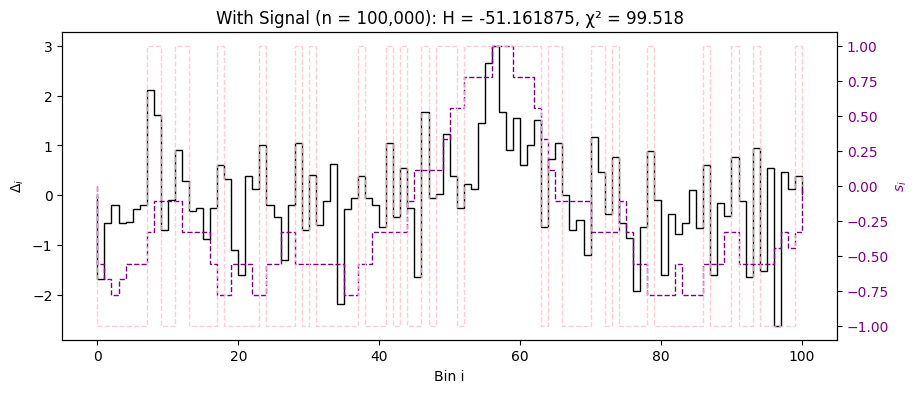

In [35]:
# model dependent
e_i = np.array([len(signals) / n_bins] * n_bins)

delta_i, o_edges, anneal_res_si, H_signal = matchev_annealing(signals, e_i, n_bins=n_bins)
# anneal_res_si_smooth = rolling_mean_padded(anneal_res_si, smoothing_window)
anneal_res_si_smooth = rolling_mean(anneal_res_si, smoothing_window)
fig = plot_deltas_and_s(delta_i, o_edges, anneal_res_si_smooth)
plt.stairs(anneal_res_si, o_edges, color="pink", ls="--", alpha=0.8)
chi_2_signal = np.sum(delta_i**2)
plt.title(f"With Signal (n = {len(signals):,}): H = {H_signal}, χ² = {chi_2_signal}");

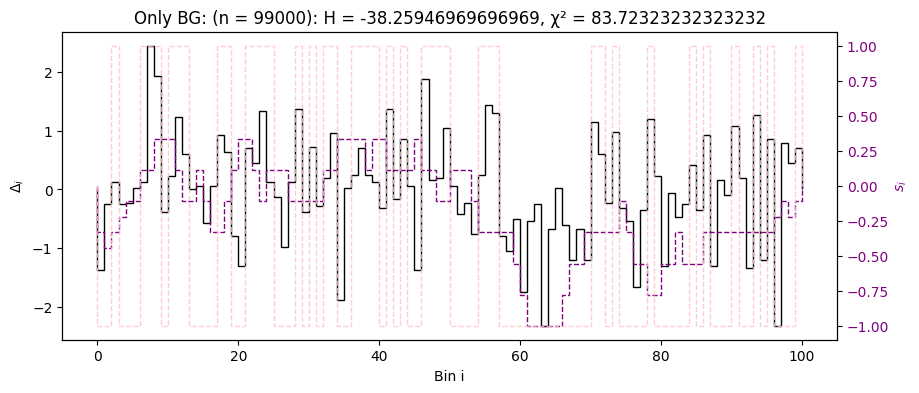

In [36]:
# only bg
e_i = np.array([len(bg_signals) / n_bins] * n_bins)

delta_i, o_edges, anneal_res_si, H_bg = matchev_annealing(bg_signals, e_i)
anneal_res_si_smooth = rolling_mean_padded(anneal_res_si, smoothing_window)
# anneal_res_si_smooth = rolling_mean(anneal_res_si, smoothing_window)
fig = plot_deltas_and_s(delta_i, o_edges, anneal_res_si_smooth)
plt.stairs(anneal_res_si, o_edges, color="pink", ls="--", alpha=0.8)
chi_2_bg = np.sum(delta_i**2)
plt.title(f"Only BG: (n = {len(bg_signals)}): H = {H_bg}, χ² = {chi_2_bg}");

In [37]:
H_rel_diff = (H_signal - H_bg) / H_bg
print(f"Relative difference in H: {H_rel_diff:.2%}")

chi2_rel_diff = (chi_2_signal - chi_2_bg) / chi_2_bg
print(f"Relative difference in χ²: {chi2_rel_diff:.2%}")

Relative difference in H: 33.72%
Relative difference in χ²: 18.87%


# Dev

In [7]:
generator = np.random.default_rng(1337)

In [8]:
n_bg = 9_900*10
n_signals = 100*10
n_bins = 100
bg_signals = generator.uniform(0, 100, n_bg)
real_signals = generator.normal(60, 5, n_signals)
signals = np.concatenate([bg_signals, real_signals])

In [9]:
# observed
o_i, o_edges = np.histogram(signals, bins=n_bins, range=(0, 100))
e_i = np.array([len(signals) / n_bins] * n_bins)

In [10]:
delta_i = (o_i - e_i) / np.sqrt(e_i)

Text(0, 0.5, '$\\Delta_i$')

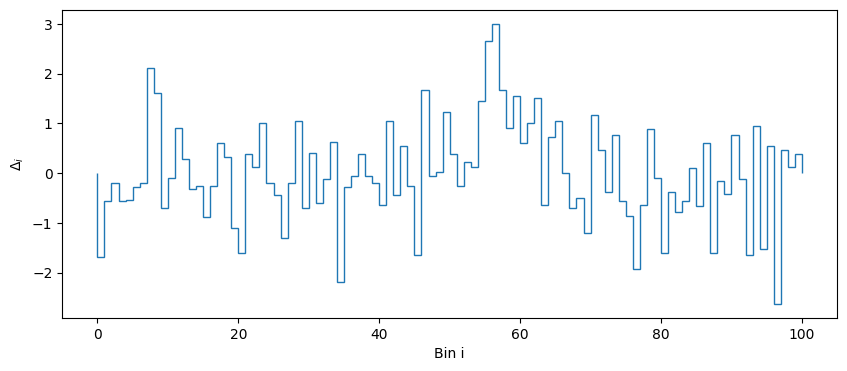

In [11]:
plt.figure(figsize=(10, 4))
plt.stairs(delta_i, o_edges, label="Data")
plt.xlabel("Bin i")
plt.ylabel(r"$\Delta_i$")

In [12]:
chi2 = np.sum(delta_i ** 2)
chi2

99.518

In [13]:
# only nearest neighbours, i.e. matrix with 0s on the diagonal and 1s on the one upper and one lower diagonal
w_ij = np.zeros((n_bins, n_bins))
for i in range(n_bins):
    if i > 0:
        w_ij[i, i - 1] = 1./2.
    if i < n_bins - 1:
        w_ij[i, i + 1] = 1./2.
print(w_ij)

[[0.  0.5 0.  ... 0.  0.  0. ]
 [0.5 0.  0.5 ... 0.  0.  0. ]
 [0.  0.5 0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.5 0. ]
 [0.  0.  0.  ... 0.5 0.  0.5]
 [0.  0.  0.  ... 0.  0.5 0. ]]


Hamiltonian:   
$$ H = -\sum_{i=1}^N \frac{|\Delta_i| \Delta_i}{2} \frac{s_i}{2} - \frac{\lambda}{2} \sum_{ij} \omega_{ij} \frac{(\Delta_i + \Delta_j)^2}{4} \frac{1+s_i s_j}{2} $$

In [14]:
def Hamiltonian(s_i, delta_i, w_ij, lamb):
    r"""
    Computes the Ising Hamiltonian:

    $$ H = -\sum_{i=1}^N \frac{|\Delta_i| \Delta_i}{2} \frac{s_i}{2} 
         - \frac{\lambda}{2} \sum_{ij} \omega_{ij} \frac{(\Delta_i + \Delta_j)^2}{4} \frac{1+s_i s_j}{2} $$

    Parameters:
    - s_i: Array of spin values (+1 or -1)
    - delta_i: Array of deviations Δ_i
    - w_ij: Interaction matrix ω_ij
    - lamb: Coupling parameter λ

    Returns:
    - Hamiltonian value
    """
    a = - np.sum(np.abs(delta_i) * delta_i * s_i) / 4  # First term

    dd = np.add.outer(delta_i, delta_i)**2 / 4.0  # Efficient pairwise Δ sum
    ss = (1 + np.outer(s_i, s_i)) / 2.0  # Interaction factor
    
    b = - (lamb / 2.0) * np.sum(w_ij * dd * ss)  # Second term
    
    return a + b

In [15]:
# s_i either -1 or 1
# random initialisation
s_i = generator.choice([-1, 1], n_bins)

Text(0.5, 1.0, 'random spins')

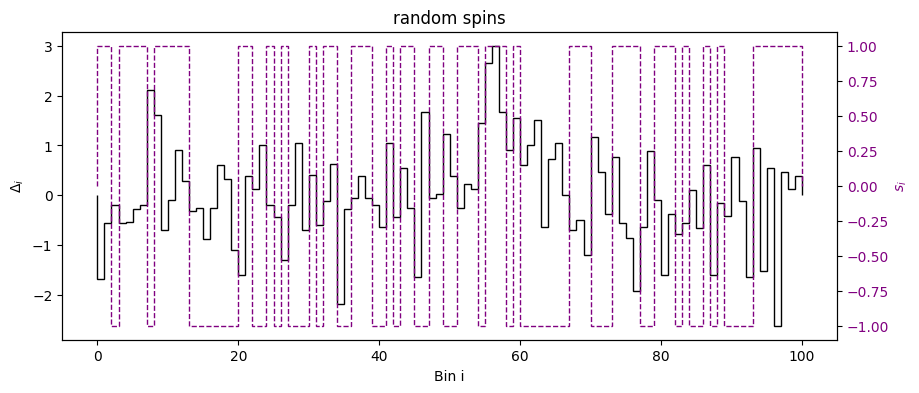

In [16]:
def plot_deltas_and_s(delta_i, s_i):
    ax1_color = "black"
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.stairs(delta_i, o_edges, label="Data", color=ax1_color)
    ax1.set_xlabel("Bin i")
    ax1.set_ylabel(r"$\Delta_i$")

    if s_i is None:
        return fig

    # on a new y-axis, plot s_i
    ax2_color = "purple"
    ax2 = ax1.twinx()
    ax2.set_ylabel("$s_i$", color=ax2_color)
    ax2.stairs(s_i, o_edges, color="purple", ls="--")
    ax2.tick_params(axis="y", labelcolor=ax2_color)

    return fig

fig = plot_deltas_and_s(delta_i, s_i)
plt.title("random spins")

In [17]:
Hamiltonian(s_i, delta_i, w_ij, 1)

-16.397375

QUBO formulation
$
\begin{align}
H &= C_A + C_B + \sum_i Q_i x_i + \sum_{ij} Q_{ij} x_i x_j \\
Q_i &= -\frac{|\Delta_i| \Delta_i}{2} + \lambda \sum_j w_{ij} \frac{(\Delta_i + \Delta_j)^2}{4} \\
Q_{ij} &= \lambda \omega_{ij} \frac{(\Delta_i + \Delta_j)^2}{4}\\
C_A &= \sum_i \frac{|\Delta_i| \Delta_i}{4} \\
C_B &= - \frac{\lambda}{2} \sum_{ij} w_{ij} \frac{(\Delta_i + \Delta_j)^2}{4}
\end{align}
$

In [18]:
def calc_Qi(delta_i, w_ij, lamb):
    dd = (delta_i[:, np.newaxis] + delta_i[np.newaxis, :])**2 / 4.0
    return - np.abs(delta_i) * delta_i / 2.0 + lamb * np.sum(w_ij * dd, axis=1)

def calc_Qij(delta_i, w_ij, lamb):
    dd = (delta_i[:, np.newaxis] + delta_i[np.newaxis, :])**2 / 4.0
    return - lamb * w_ij * dd

def calc_CA(delta_i, w_ij, lamb):
    dd = np.abs(delta_i) * delta_i / 4
    return np.sum(dd)

def calc_CB(delta_i, w_ij, lamb):
    dd = (delta_i[:, np.newaxis] + delta_i[np.newaxis, :])**2 / 4.0
    return - (lamb / 2.0) * np.sum(w_ij * dd)

def calc_H_QUBO(s_i, delta_i, w_ij, lamb):
    x_i = (s_i + 1) / 2
    a = np.sum(calc_Qi(delta_i, w_ij, lamb) * x_i)
    b = np.sum(calc_Qij(delta_i, w_ij, lamb) * np.outer(x_i, x_i))
    c = calc_CA(delta_i, w_ij, lamb)
    d = calc_CB(delta_i, w_ij, lamb)
    print(f"{a=}, {b=}, {c=}, {d=}")
    return a + b + c + d

In [19]:
calc_H_QUBO(s_i, delta_i, w_ij, 1)

a=36.108, b=-24.702750000000005, c=1.323500000000001, d=-29.126125000000005


-16.39737500000001

In [20]:
Hamiltonian(s_i, delta_i, w_ij, 1)

-16.397375

In [21]:
Qij = calc_Qij(delta_i, w_ij, 1)
Qi = calc_Qi(delta_i, w_ij, 1)
Q = Qij + Qi * np.identity(len(Qi))
Q

array([[ 2.034625, -0.630125,  0.      , ...,  0.      ,  0.      ,
        -0.      ],
       [-0.630125,  0.864125, -0.072   , ...,  0.      ,  0.      ,
        -0.      ],
       [ 0.      , -0.072   ,  0.162   , ...,  0.      ,  0.      ,
        -0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.510625, -0.045125,
        -0.      ],
       [ 0.      ,  0.      ,  0.      , ..., -0.045125,  0.069125,
        -0.032   ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      , -0.032   ,
        -0.04    ]])

In [22]:
def Q_matrix_to_dict(Q_matrix:np.ndarray) -> dict:
    assert Q_matrix.shape == (Q_matrix.shape[0], Q_matrix.shape[0])
    qubo_dict = {}
    for i in range(Q_matrix.shape[0]):
        for j in range(i, Q_matrix.shape[1]):
            if Q_matrix[i, j] != 0:
                qubo_dict[(i, j)] = Q_matrix[i, j]
    return qubo_dict
QUBO_dict = Q_matrix_to_dict(Q)

In [23]:
anneal_res = qv.sim.anneal_qubo(QUBO_dict,
                   num_anneals=5,
                   anneal_duration=4000,
                   initial_state=None,
                   temperature_range=None,
                   schedule="geometric",
                   in_order=True,
                   seed=42)
anneal_res

[AnnealResult(state={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 1, 24: 0, 25: 0, 26: 0, 27: 0, 28: 1, 29: 0, 30: 1, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 1, 38: 0, 39: 0, 40: 0, 41: 1, 42: 0, 43: 1, 44: 0, 45: 0, 46: 1, 47: 0, 48: 1, 49: 1, 50: 1, 51: 0, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 0, 64: 1, 65: 1, 66: 0, 67: 0, 68: 0, 69: 0, 70: 1, 71: 1, 72: 0, 73: 1, 74: 0, 75: 0, 76: 0, 77: 0, 78: 1, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 1, 87: 0, 88: 0, 89: 0, 90: 1, 91: 0, 92: 0, 93: 1, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 1}, value=-7.69575, spin=False),
 AnnealResult(state={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 1, 24: 0, 25: 0, 26: 0, 27: 0, 28: 1, 29: 0, 30: 1, 31: 0, 32: 0, 33: 0, 34: 0, 35:

In [24]:
anneal_res_xi = np.array([anneal_res.best.state[k] for k in anneal_res.best.state.keys()])

In [25]:
anneal_res_si = 2 * anneal_res_xi - 1
anneal_res_si

array([-1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1, -1, -1,
        1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1, -1, -1, -1,
       -1, -1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1,
       -1, -1,  1,  1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,
       -1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1,  1])

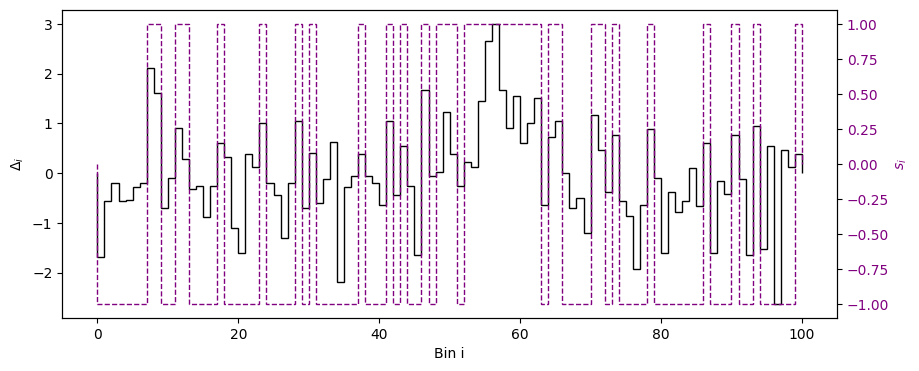

In [26]:
fig = plot_deltas_and_s(delta_i, anneal_res_si)

In [27]:
Hamiltonian(anneal_res_si, delta_i, w_ij, 1)

-51.161875

In [28]:
def rolling_mean(arr, window_size):
    """
    Compute the rolling mean of a 1D NumPy array.

    Parameters:
    arr (numpy.ndarray): Input array.
    window_size (int): Size of the moving window.

    Returns:
    numpy.ndarray: Array of rolling means.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1")
    if window_size > len(arr):
        raise ValueError("Window size cannot be larger than the array length")

    return np.convolve(arr, np.ones(window_size) / window_size, mode='same')

def rolling_mean_padded(arr, window_size, pad_mode='constant'):
    """
    Compute the rolling mean of a 1D NumPy array with padding to maintain the same length.

    Parameters:
    arr (numpy.ndarray): Input array.
    window_size (int): Size of the moving window.
    pad_mode (str): Padding mode for numpy.pad (default is 'edge').

    Returns:
    numpy.ndarray: Array of rolling means with the same length as input.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1")
    
    half_window = (window_size - 1) // 2  # Number of values to pad on each side
    
    # Pad the array to handle edge effects
    padded_arr = np.pad(arr, (half_window, half_window), mode=pad_mode)
    
    # Compute rolling mean using convolution
    result = np.convolve(padded_arr, np.ones(window_size) / window_size, mode='valid')
    
    return result

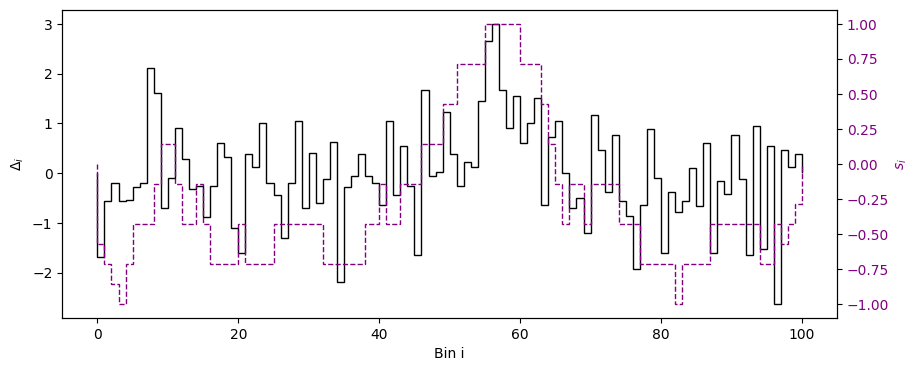

In [29]:
anneal_res_si_smooth = rolling_mean_padded(anneal_res_si, 7)
fig = plot_deltas_and_s(delta_i, anneal_res_si_smooth)